# Part II: Fit Failure

In [1]:
import os
os.environ['ZFIT_DISABLE_TF_WARNINGS'] = '1'
import zfit
import tensorflow as tf
tf.keras.backend.set_floatx('float64')
import numpy as np
import matplotlib as mpl
if os.path.exists('lhcbStylerc'):
    mpl.rc_file('lhcbStylerc')
import socket
if 'jupyter-schmitse-' in socket.gethostname():
    mpl.rcParams['text.usetex'] = False

import matplotlib.pyplot as plt
import boost_histogram as bh
from scipy import stats

# our plotting function form before
from Helpers import plot_fit

# used for interactive widgets
import ipywidgets as widgets

2022-11-24 11:33:52.103591: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Failing Fits

There is a plethora of reasons why fits may fail and often more than one reason play a role. 
In the following i will try to illustrate some extreme examples of failure reasons. 
Inspiration for most of the examples stems from [Hans's pyHEP talk](https://nbviewer.org/github/HDembinski/PyHEP-2022-iminuit/blob/main/iminuit.ipynb). 

### 1. Initial Parameters

Initial parameters are the **starting point** of the minimisation process. If they are chosen far away from the minimum it may be impossible for the minimiser to find the minimum. 

In [2]:
# random dataset
zfit.settings.set_seed(420)
rng = np.random.default_rng(seed=1337)
data_gauss = rng.normal(0.5, 0.1, size=(3000,))

# zfit observable and data
obs = zfit.Space('Observable', limits=(0, 1))
data_gauss_zfit = zfit.Data.from_numpy(obs=obs, array=data_gauss)

2022-11-24 11:33:55.008245: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [3]:
# setup a model to illustrate failures
mu = zfit.Parameter('mu', 0.5, -1, 50)
sigma = zfit.Parameter('sigma', 0.1, 1e-4, 2)
gauss = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma, name='Gauss')
minimiser = zfit.minimize.Minuit()

# setup the loss for the failure
nll_fail = zfit.loss.UnbinnedNLL(model=gauss, data=data_gauss_zfit)

def fit_gauss(mu_init: float=0, sigma_init: float=0)->None:
    """ brief fit after setting parameters mu and sigma """
    mu.set_value(float(mu_init))
    sigma.set_value(float(sigma_init))
    fit_result = minimiser.minimize(nll_fail)
    print(f'Fit converged after {fit_result.info["minuit"].nfcn} calls.')
    print(fit_result)

sl_mu = widgets.FloatSlider(value=0.5, min=-1, max=10., step=0.01, description= 'Mu: ', 
                            continuous_update=False, orientation='horizontal', 
                            readout=True, readout_format='.2f')
sl_sigma = widgets.FloatSlider(value=0.1, min=0, max=2., step=0.01, description= 'Sigma: ', 
                               continuous_update=False, orientation='horizontal', 
                               readout=True, readout_format='.2f')
widgets.interactive(fit_gauss, mu_init=sl_mu, sigma_init=sl_sigma)

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='Mu: ', max=10.0, min=-1.0, …

Depending on the choice of initial parameters, the fit succeeds or even fails because of `nan`s in the cost function!

It is usually useful to infer starting parameters from a source like **simulation** or the **data** itself. 
In our (simple) example we know that the generation of the dataset uses $\mu=0.5$ and $\sigma=0.1$, so we may choose this. Instead we can estimate both the mean as well as the width with the (ML) estimators of the arithmetic mean and the empirical standard deviation. 

Sensible starting values may decide how fast and **if** your fit will succeed! In more difficult scenarios, bad choice of initial parameter values may also result in the fit not converging to the global minimum. 

## Parameter Ranges

Without sensible limits on your parameter space a fit may "**run away**" into some exotic parameter space (these might even be **unphysical**, such as a negative yield for a component). 
In order to prevent this, the parameters in question should be **limited** within a **reasonable region**. 
These limits should not be too tight in order to not interfere with the uncertainty computation or the minimisation. 

In order to visualise this we will look at a more complex toy example, that we already know from the previous notebook:

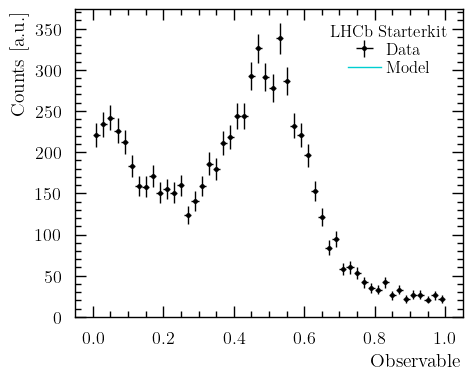

In [4]:
# additional background in the dataset
data_exp = rng.exponential(0.4, size=(5000,))
data = np.append(data_gauss, data_exp[data_exp<=1])
data_zfit = zfit.Data.from_numpy(obs=obs, array=data)

# visualise the new data
plot_fit(data, [], [], obs)

As in the previous part, we can build a composite model of an exponential and a gaussian to describe this dataset. 
Lets play around with the ranges of the parameters and their initial values:

In the following example, the fit from the previous part is repeated without limits on the yields and the slope of the exponential: 

In [5]:
# slope and yield parameters without limits
slope_bkg = zfit.Parameter('slope_bkg', -0.01, None, None)

n_signal = zfit.Parameter('n_signal', 1, None, None)
n_bkg = zfit.Parameter('n_bkg', 1, None, None)

# create the pdfs with the extended term for the yields
gaussian = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma, name='Signal')
gaussian_ext = gaussian.create_extended(n_signal)

exponential = zfit.pdf.Exponential(obs=obs, lam=slope_bkg, name='Background')
exponential_ext = exponential.create_extended(n_bkg)

# build the model as the sum of the gaussian and the exponential functions
model = zfit.pdf.SumPDF([gaussian_ext, exponential_ext])

# loss function is now extended unbinned NLL
nll = zfit.loss.ExtendedUnbinnedNLL(model=model, data=data_zfit)

result_norange = minimiser.minimize(nll)
result_norange

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_1, Composed_autoparam_2]] data=[<zfit.core.data.Data object at 0x7fb3d89572e0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ False   │ True        │ False            │ 0.00015 │ -54455.7    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name         value  (rounded)    at limit
---------  ------------------  ----------
n_signal              7568.57       False
n_bkg                0.134316       False
mu                   0.320756       False
sigma                0.290359       False
slope_bkg            -1419.46       False

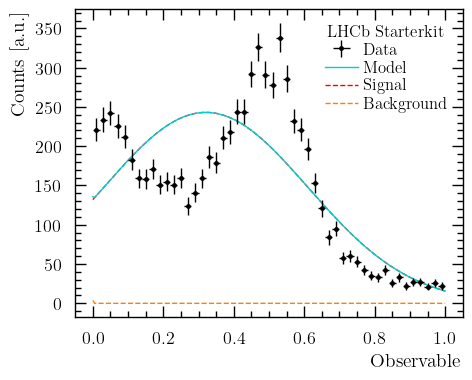

In [6]:
basis = np.linspace(0, 1, 200)
model_np = model.pdf(basis).numpy() * (n_signal.numpy()+n_bkg.numpy())

plot_fit(data, basis, model_np, obs, zmodel=model)

In [7]:
result_norange.info['minuit']

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -5.446e+04                 │              Nfcn = 967              │
│ EDM = 0.000155 (Goal: 0.001)     │            time = 3.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           ABOVE call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n_signal  │ 7.5686e3  │ 0.0000e3  │            │            │         │         │       │
│ 1 │ n_bkg     │ 1.3432e-1 │ 0.0000e-1 │            │            │         │         │       │
│ 2 │ mu        │ 3.2076e-1 │ 0.0000e-1 │            │            │   -1    │   50    │       │
│ 3 │ sigma     │ 2.9036e-1 │ 0.0000e-1 │            │            │ 0.0001  │    2    │       │
│ 4 │ slope_bkg │ -1.4195e3 │ 0.0000e3  │            │            │         │         │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

## What happened?

Due to subpar initial values and missing limits, some parameters run into a region where the minimiser cannot recover them. The minimum is **invalid** since either the EDM, HESSE condition, or other conditions are not met and the fit halted because the call limit was reached. 

Note: if you are lucky, a fit like this may still converge. Generally they are **very unstable** and you should avoid leaving all parameters completely unbounded. 

## How can we fix it? 

We can, without playing around with the initial parameters, introduce **limits** to the parameters to constrain them in the region where we expect them to be:

In [8]:
# "reset" the slope parameter and add limits. Usually you add limits 
# in the constructor this is just for illustration
slope_bkg.set_value(-0.01)
slope_bkg.lower_limit = -7
slope_bkg.upper_limit = -1e-5

# reset the yields and constrain them to be positive
n_signal.set_value(1)
n_signal.lower_limit = 0
n_bkg.set_value(1)
n_bkg.lower_limit = 0

# reset the signal shape parameters
mu.set_value(0.5)
sigma.set_value(0.1)

# rerun the minimisation process..
result = minimiser.minimize(nll)
result.hesse(name='minuit_hesse')
result

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_1, Composed_autoparam_2]] data=[<zfit.core.data.Data object at 0x7fb3d89572e0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00054 │ -54908.26   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name         value  (rounded)    minuit_hesse    at limit
---------  ------------------  --------------  ----------
n_signal              2953.62     +/-      92       False
n_bkg                 4614.65     +/-   1e+02       False
mu                   0.499846     +/-  0.0028       False
sigma                0.098729     +/-  0.0029       False
slope_bkg            -2.47022     +/-   0.075       Fa

In [9]:
result.info['minuit']

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -5.491e+04                 │              Nfcn = 844              │
│ EDM = 0.000541 (Goal: 0.001)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n_signal  │  2.95e3   │  0.09e3   │            │            │    0    │         │       │
│ 1 │ n_bkg     │  4.61e3   │  0.10e3   │            │            │    0    │         │       │
│ 2 │ mu        │  0.4998   │  0.0028   │            │            │   -1    │   50    │       │
│ 3 │ sigma     │  0.0987   │  0.0029   │            │            │ 0.0001  │    2    │       │
│ 4 │ slope_bkg │   -2.47   │   0.08    │            │            │   -7    │ -1e-05  │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬───────────────────────────────────────────────────┐
│           │  n_signal     n_bkg        mu     sigma slope_bkg │
├───────────┼───────────────────────────────────────────────────┤
│  n_signal │  8.49e+03 -5.53e+03   -0.0405     0.145     -3.16 │
│     n_bkg │ -5.53e+03  1.01e+04    0.0405    -0.145      3.16 │
│        mu │   -0.0405    0.0405  7.85e-06 -1.57e-06 -2.01e-05 │
│     sigma │     0.145    -0.145 -1.57e-06  8.15e-06 -7.73e-05 │
│ slope_bkg │     -3.16      3.16 -2.01e-05 -7.73e-05   0.00568 │
└───────────┴───────────────────────────────────────────────────┘

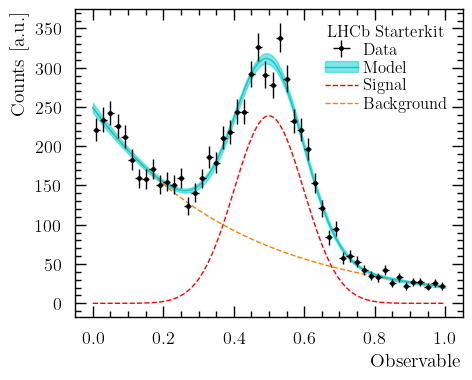

In [10]:
def eval_zfit_model(model: zfit.pdf.BasePDF, basis:np.ndarray, pars: np.ndarray)->np.ndarray:
    """ brief helper to evaluate model for given parameters and basis """
    with zfit.param.set_values([n_signal, n_bkg, mu, sigma, slope_bkg], pars):
        pdf = model.pdf(basis) * (n_signal.numpy()+n_bkg.numpy())
    return pdf

# model central values
basis = np.linspace(0, 1, 200)
model_np = model.pdf(basis).numpy() * (n_signal.numpy()+n_bkg.numpy())

# the uncertainty computation on our model given the parameters
mean_params = [result.params[p]['value'] for p in result.params.keys()]
covariance = result.covariance()
rnd_pars = rng.multivariate_normal(mean_params, covariance, 200,)
smodel_np = np.std([eval_zfit_model(model, basis, pars) for pars in rnd_pars], ddof=1, axis=0)

plot_fit(data, basis, model_np, obs, smodel=smodel_np, zmodel=model)

Introducing sensible **limits** has helped the fit converge to a meaningful result! Choosing better starting values is likely to also help in the situation above. 

## Underconstrained Parameters

The data might not be able to allow for determination of a combination of parameters. In the theory, you might expect a sum of two exponential slopes, $\mathrm{f}(x) = e^{(\gamma_1 + \gamma_2)\cdot x}$, that describe your background. 

Fitting this model might not work, due to the **strongly correlated** parameters that occur because the data cannot tell them apart. 


In [11]:
# Parameters for an underconstrained exponential
slope_bkg_2 = zfit.Parameter('slope_2', -0.8**-1, -20, 10)
# function to combine slopes
slope_fn = lambda s1, s2: s1 + s2
# this is an inline function, you may also write:
# def slope_fn(s1: float, s2: float)->float:
#     return s1 + s2

# Slope parameter from two individual slopes as **ComposedParameter**
slope_ucnstr = zfit.param.ComposedParameter('slope_unconstr', slope_fn, [slope_bkg, slope_bkg_2])

# 2nd exponential function
expo_ucnstr = zfit.pdf.Exponential(obs=obs, lam=slope_ucnstr, name='unconstrained_exponential')
expo_ucnstr_ext = expo_ucnstr.create_extended(n_bkg)

# sum of both exponentials and gaussian
model_underconstraint = zfit.pdf.SumPDF([gaussian_ext, expo_ucnstr_ext])

# -nll with new model
nll_underconstraint = zfit.loss.ExtendedUnbinnedNLL(model=model_underconstraint, data=data_zfit)

In [12]:
result_underconstraint = minimiser.minimize(nll_underconstraint)
result_underconstraint.hesse(name='minuit_hesse')
result_underconstraint

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_4, Composed_autoparam_5]] data=[<zfit.core.data.Data object at 0x7fb3d89572e0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 3.5e-06 │ 838.4134    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name         value  (rounded)    minuit_hesse    at limit
---------  ------------------  --------------  ----------
n_signal              2952.23     +/-      92       False
n_bkg                 4616.57     +/-   1e+02       False
mu                   0.499895     +/-  0.0028       False
sigma               0.0986886     +/-  0.0028       False
slope_bkg            -1.89347     +/-    0.96       Fa

In [13]:
result_underconstraint.info['minuit']

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 838.4                      │              Nfcn = 172              │
│ EDM = 3.52e-06 (Goal: 0.001)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n_signal  │  2.95e3   │  0.09e3   │            │            │    0    │         │       │
│ 1 │ n_bkg     │  4.62e3   │  0.10e3   │            │            │    0    │         │       │
│ 2 │ mu        │  0.4999   │  0.0028   │            │            │   -1    │   50    │       │
│ 3 │ sigma     │  0.0987   │  0.0028   │            │            │ 0.0001  │    2    │       │
│ 4 │ slope_bkg │   -1.9    │    0.9    │            │            │   -7    │ -1e-05  │       │
│ 5 │ slope_2   │   -0.6    │    1.0    │            │            │   -20   │   10    │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬─────────────────────────────────────────────────────────────┐
│           │  n_signal     n_bkg        mu     sigma slope_bkg   slope_2 │
├───────────┼─────────────────────────────────────────────────────────────┤
│  n_signal │  8.43e+03 -5.48e+03     -0.04     0.143     -1.56     -1.58 │
│     n_bkg │ -5.48e+03  1.01e+04      0.04    -0.143      1.56      1.58 │
│        mu │     -0.04      0.04  7.82e-06 -1.55e-06    -1e-05 -1.01e-05 │
│     sigma │     0.143    -0.143 -1.55e-06  8.11e-06 -3.81e-05 -3.86e-05 │
│ slope_bkg │     -1.56      1.56    -1e-05 -3.81e-05     0.914    -0.911 │
│   slope_2 │     -1.58      1.58 -1.01e-05 -3.86e-05    -0.911     0.914 │
└───────────┴─────────────────────────────────────────────────────────────┘

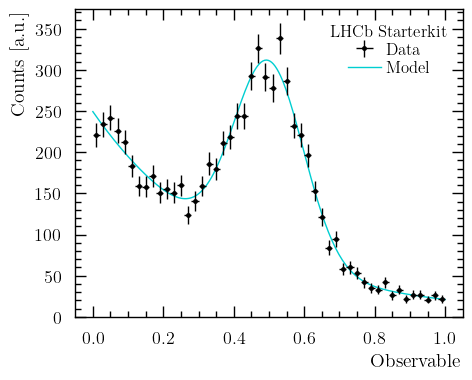

In [14]:
basis = np.linspace(0, 1, 200)
model_uc_np = model_underconstraint.pdf(basis).numpy() * (n_signal.numpy()+n_bkg.numpy())

plot_fit(data, basis, model_uc_np, obs)

## What happened? 

Due to the strong correlations of the two background slopes, due to the missing constraining power of the data, the minimisation is very unstable. Note that the slopes are almost **perfectly anti-correlated**. 

In this case the fit claims to be converged at a valid minimum, however we see that the hessian matrix does not fulfill all requirements and consequently at least the uncertainties on our parameters are not to be trusted. These cases might be difficult to spot, since the projection of the fit onto the data looks good. 

Generally, fits with underconstrained parameters are **very unstable** and one should avoid this at all cost. 

## How to fix this? 

Construct models that are **fully constrainable** by the data that you collected. If the data is not able to constrain the parameters good enough, external constraints may be used. The external constraints can be inferred from other measurements or simulation. 

## External Constraints

External constraints on one or several parameters can be added to the loss in `zfit` via the `Constraints`. 
There are different constraint options, ranging from expressing a quantity based on others to adding a function to the cost that will penalise certain scenarios. 

Frequently used constraints are **gaussian constraints**, where a parameter is constrained to be around a value, given a gaussian $68\,\%$ coverage interval. In general gaussian constraints can be added to multiple parameters also if there are correlations involved. The parameter vector $\vec{x}$ may be constrained around a mean $\vec{\mu}$ given the covariance matrix $\boldsymbol{\Sigma}$ using a multivariate normal distribution as likelihood
$$ \mathcal{L}^{\rm constraint} = (2\pi)^{-\frac{k}{2}} \left(\det{\boldsymbol{\Sigma}}\right)^{-\frac{1}{2}} \exp\left(-\frac{1}{2} (\vec{x} - \vec{\mu})^{\rm T} \boldsymbol{\Sigma}^{-1} (\vec{x}-\vec{\mu})\right). $$
The negative log likelihood of this simplifies to a $\chi^2$-like expression
$$ -\log\mathcal{L}^{\rm constraint} = \mathcal{N} + (\vec{x} - \vec{\mu})^{\rm T} \boldsymbol{\Sigma}^{-1} (\vec{x}-\vec{\mu}) .$$

Lets add a fictional constraint to the previous example and see if we can improve the situation:

In [15]:
# add a gaussian penalty depending on n_bkg2. Penalise moving away from "1000" with a sigma of 50
# note that for a multivariate gaussian, uncertainty is the covariance matrix **not** the sigmas
constraint = zfit.constraint.GaussianConstraint(slope_bkg_2, observation=-1, uncertainty=1e-1)

# build the cost function including the constraint
nll_constr = zfit.loss.ExtendedUnbinnedNLL(model=model_underconstraint, data=data_zfit, constraints=[constraint])

# minimise and run hesse
result_constr = minimiser.minimize(nll_constr)
result_constr.hesse(name='minuit_hesse')
result_constr

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_4, Composed_autoparam_5]] data=[<zfit.core.data.Data object at 0x7fb3d89572e0>] constraints=[<zfit.core.constraint.GaussianConstraint object at 0x7fb3d426b220>]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 2.5e-05 │ 991.4153    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name         value  (rounded)    minuit_hesse    at limit
---------  ------------------  --------------  ----------
n_signal              2952.53     +/-      92       False
n_bkg                 4616.42     +/-   1e+02       False
mu                   0.499896     +/-  0.0028       False
sigma               0.0986816     +/-  0.0029 

In [16]:
result_constr.info['minuit']

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 991.4                      │              Nfcn = 183              │
│ EDM = 2.49e-05 (Goal: 0.001)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n_signal  │  2.95e3   │  0.09e3   │            │            │    0    │         │       │
│ 1 │ n_bkg     │  4.62e3   │  0.10e3   │            │            │    0    │         │       │
│ 2 │ mu        │  0.4999   │  0.0028   │            │            │   -1    │   50    │       │
│ 3 │ sigma     │  0.0987   │  0.0029   │            │            │ 0.0001  │    2    │       │
│ 4 │ slope_bkg │   -1.47   │   0.12    │            │            │   -7    │ -1e-05  │       │
│ 5 │ slope_2   │   -1.0    │    0.1    │            │            │   -20   │   10    │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬─────────────────────────────────────────────────────────────┐
│           │  n_signal     n_bkg        mu     sigma slope_bkg   slope_2 │
├───────────┼─────────────────────────────────────────────────────────────┤
│  n_signal │  8.49e+03 -5.54e+03   -0.0405     0.145     -3.16  0.000458 │
│     n_bkg │ -5.54e+03  1.02e+04    0.0405    -0.145      3.16 -0.000458 │
│        mu │   -0.0405    0.0405  7.84e-06 -1.57e-06 -2.01e-05  3.99e-09 │
│     sigma │     0.145    -0.145 -1.57e-06  8.15e-06 -7.75e-05  1.07e-08 │
│ slope_bkg │     -3.16      3.16 -2.01e-05 -7.75e-05    0.0157     -0.01 │
│   slope_2 │  0.000458 -0.000458  3.99e-09  1.07e-08     -0.01      0.01 │
└───────────┴─────────────────────────────────────────────────────────────┘

Adding the constrained resolved the ambiguity between the slopes, even though are still strongly correlated. 
Make sure your penalty is not too strong if the data is able to constrain the parameters in question better. 

## Too Tight Limits

While, as shown above, ranges are important they must not be too tight. 

Lets move back to the initial example but tighten the range of some parameters. 

In [17]:
# tighten the limits on the width parameter
sigma.upper_limit = 0.1000
sigma.lower_limit = 0.0984

# rerun minimisation and hesse
result_limit = minimiser.minimize(nll)
result_limit.hesse(name='minuit_hesse')
result_limit

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_1, Composed_autoparam_2]] data=[<zfit.core.data.Data object at 0x7fb3d89572e0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00015 │ -54908.26   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name         value  (rounded)    minuit_hesse    at limit
---------  ------------------  --------------  ----------
n_signal              2946.41     +/-     1.4       False
n_bkg                 4622.06     +/-     1.4       False
mu                   0.499908     +/-  0.0027       False
sigma               0.0984001     +/- 1.9e-05       False
slope_bkg            -2.46758     +/-   0.065       Fa

In [18]:
# comparison: the original result
result

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_1, Composed_autoparam_2]] data=[<zfit.core.data.Data object at 0x7fb3d89572e0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00054 │ -54908.26   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name         value  (rounded)    minuit_hesse    at limit
---------  ------------------  --------------  ----------
n_signal              2953.62     +/-      92       False
n_bkg                 4614.65     +/-   1e+02       False
mu                   0.499846     +/-  0.0028       False
sigma                0.098729     +/-  0.0029       False
slope_bkg            -2.47022     +/-   0.075       Fa

Both the central values and uncertainties of **all** parameters changed. While in this example the movement is not very big, one cannot easily predict the problems that arise here. Note also that the zfit fit result does not show parameters being at limit!

In [20]:
result_limit.info['minuit']

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -5.491e+04                 │              Nfcn = 135              │
│ EDM = 0.000148 (Goal: 0.001)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n_signal  │ 2.9464e3  │ 0.0014e3  │            │            │    0    │         │       │
│ 1 │ n_bkg     │ 4.6221e3  │ 0.0014e3  │            │            │    0    │         │       │
│ 2 │ mu        │  0.4999   │  0.0027   │            │            │   -1    │   50    │       │
│ 3 │ sigma     │  0.0984   │  0.0011   │            │            │ 0.0984  │   0.1   │       │
│ 4 │ slope_bkg │   -2.47   │   0.07    │            │            │   -7    │ -1e-05  │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────┬───────────────────────────────────────────────────┐
│           │  n_signal     n_bkg        mu     sigma slope_bkg │
├───────────┼───────────────────────────────────────────────────┤
│  n_signal │      1.93 -0.000306 -3.15e-06 -2.12e-08  -0.00044 │
│     n_bkg │ -0.000306      1.93  2.01e-06  1.35e-08   0.00028 │
│        mu │ -3.15e-06  2.01e-06  7.49e-06  7.03e-10 -3.95e-05 │
│     sigma │ -2.12e-08  1.35e-08  7.03e-10  3.49e-10  1.38e-08 │
│ slope_bkg │  -0.00044   0.00028 -3.95e-05  1.38e-08   0.00427 │
└───────────┴───────────────────────────────────────────────────┘

The `Minuit` object in the fit result info does indeed warn us about the parameters being at limit here. 

## Recap

Explored some common pitfalls of fitting and how to avoid them. 
 - Initial Values: Choose them carefully, close to where you expect the result to be. 
 - Parameter Ranges: Constrain them tightly enough to your expectation but not too tight to avoid problems in the uncertainty estimation
 - Underconstrained Parameters: Avoid building models that are underconstrained. In case it is not possible, add external constraints. 
 - More on constraints will be explored in the following parts. 

In general, always carefully investigate all outputs that the minimisers provide. 